
# SC4002 / CE4045 / CZ4045 NLP — Assignment — Part 3.1: biLSTM

This notebook replaces the simple RNN from Part 2 with a **bidirectional LSTM (biLSTM)** as required in Part 3.1, and logs:
- Training loss per epoch
- Validation accuracy per epoch
- Final **test accuracy** and **topic-wise accuracy**


## Question 3. Enhancement 
(a) (a) Plot the training loss curve and validation accuracy curve of biLSTM and biGRU. Report their
accuracies on the test set (Part 3.1)

In [90]:

import sys, os, math, random, time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
from collections import Counter, defaultdict

import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



## Data & Vocab Loading from Part 1

In [91]:
# Load previously saved artifacts from Part 1

LOAD_PREPARED = True  
if LOAD_PREPARED:
    bundle = torch.load("trec_artifacts.pt", map_location="cpu")


    TEXT = data.Field(**bundle["text_field_kwargs"])
    LABEL = data.LabelField(**bundle["label_field_kwargs"])

    fields = [("text", TEXT), ("label", LABEL)]

    def rebuild(dataset_blob):
        examples = [
            data.Example.fromlist([item["tokens"], item["label"]], fields)
            for item in dataset_blob
        ]
        return data.Dataset(examples, fields)

    train_data = rebuild(bundle["train_examples"])
    valid_data = rebuild(bundle["valid_examples"])
    test_data  = rebuild(bundle["test_examples"])

    for ds in (train_data, valid_data, test_data):
        ds.sort_key = lambda ex: len(ex.text)

    TEXT.build_vocab([])
    TEXT.vocab.itos = bundle["text_vocab_itos"]
    unk_token = TEXT.unk_token
    if unk_token not in TEXT.vocab.itos:
        raise ValueError("UNK token missing from serialized vocabulary.")
    unk_index = TEXT.vocab.itos.index(unk_token)
    TEXT.vocab.stoi = defaultdict(lambda: unk_index,
                                  {tok: i for i, tok in enumerate(TEXT.vocab.itos)})
    TEXT.vocab.vectors = bundle["text_vocab_vectors"]

    LABEL.build_vocab([])
    LABEL.vocab.itos = bundle["label_vocab_itos"]
    LABEL.vocab.stoi = {tok: i for i, tok in enumerate(LABEL.vocab.itos)}



    pretrained_embeddings = TEXT.vocab.vectors

    train_iter, valid_iter, test_iter = data.BucketIterator.splits(
        (train_data, valid_data, test_data),
        batch_size=bundle["batch_size"],
        sort_within_batch=True,
        device=DEVICE,
    )
    print("Artifacts loaded.")

Artifacts loaded.


In [92]:

# Build from scratch via torchtext 0.4.0 ---

USE_TORCHTEXT_PIPELINE = False  

if USE_TORCHTEXT_PIPELINE:
    from torchtext import data, datasets
    # tokenizer setup
    TEXT = data.Field(tokenize='spacy', tokenizer_language='en_core_web_sm', include_lengths=True)
    LABEL = data.LabelField()
    train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

    # split train/valid (80/20)
    train_data, valid_data = train_data.split(split_ratio=0.8, random_state=random.seed(42))

    # Build vocab using your chosen pretrained vectors (Word2Vec or GloVe). Example with GloVe 100d:
    # WARNING: This may attempt a download if not present locally.
    vectors_name, vectors_dim = 'glove.6B.100d', 100
    TEXT.build_vocab(train_data, vectors=vectors_name, max_size=25000)
    LABEL.build_vocab(train_data)

    # Create iterators
    BATCH_SIZE = 64
    device = DEVICE
    train_iter, valid_iter, test_iter = data.BucketIterator.splits(
        (train_data, valid_data, test_data),
        batch_size=BATCH_SIZE,
        sort_within_batch=True,
        device=device
    )

    # Extract pretrained embeddings from vocab
    pretrained_embeddings = TEXT.vocab.vectors  # FloatTensor [vocab_size, emb_dim]
else:
    print("Skipping torchtext pipeline. Make sure you load your artifacts in Option A instead.")


Skipping torchtext pipeline. Make sure you load your artifacts in Option A instead.



## biLSTM Model

Compared to RNN, the BiLSTM leverages gate mechanisms (input, forget, output) and processes the sequence in both directions, typically yielding stronger performance on sentence classification.

Hyperparameter tuning (e.g., hidden size, number of layers, dropout) is left out here to assess the base BiLSTM (to be added later).

### Approach: 

We map tokens to vectors with an nn.Embedding layer (padding_idx=0), optionally initializing with pre-trained embeddings and freezing them if desired. 

The sequence is then encoded by a two-layer, bidirectional LSTM (batch_first=True), with dropout applied between layers when there is more than one layer. 

To handle variable-length inputs correctly and efficiently, we pack the batches with pack_padded_sequence(..., enforce_sorted=False) and unpack with pad_packed_sequence, so padded timesteps are ignored by the LSTM.  
 
Lastly, a sum pooling layer is utilized ... 

Training Details

* Objective & Optimizer. Cross-entropy loss with Adam (lr=1e-3).

* Regularization. Dropout in both the encoder stack and the head; optional gradient clipping via clip_grad_norm_ to stabilize training.

* Batching. Batches contain padded sequences with their true lengths; batching is batch_first.

* Early stopping. We train for up to 50 epochs with early stopping (patience = 3) to prevent overfitting and to capture the best checkpoint.


In [93]:

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, num_classes,
                 embeddings=None, freeze_embeddings=False, dropout=0.5, pooling='last'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        if embeddings is not None:
            self.embedding.weight.data.copy_(embeddings)
        self.embedding.weight.requires_grad = not freeze_embeddings

        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=True
        )
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * hidden_dim, num_classes)

    def forward(self, text, lengths):
        # text: [batch, seq_len]
        embedded = self.embedding(text)  # [batch, seq_len, emb_dim]

        # pack by lengths (descending expected)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h_n, c_n) = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)  # [batch, seq_len, 2*hidden]

        if self.pooling == 'last':
            # h_n: [num_layers*2, batch, hidden_dim] -> take last layer forward/backward
            fwd = h_n[-2, :, :]  # [batch, hidden_dim]
            bwd = h_n[-1, :, :]  # [batch, hidden_dim]
            sent = torch.cat([fwd, bwd], dim=1)  # [batch, 2*hidden]
        elif self.pooling == 'max':
            sent, _ = torch.max(out, dim=1)  # [batch, 2*hidden]
        elif self.pooling == 'mean':
            sent = torch.sum(out, dim=1) / (lengths.unsqueeze(1).to(out.device))  # [batch, 2*hidden]
        else:
            raise ValueError("Unknown pooling: %s" % self.pooling)

        sent = self.dropout(sent)
        logits = self.fc(sent)  # [batch, num_classes]
        return logits


In [94]:
from torch.nn.utils import clip_grad_norm_

def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()


def _extract_batch(batch):
    if hasattr(batch, 'text'):
        text, lengths = batch.text
        labels = batch.label
    else:
        text, lengths, labels = batch
    if text.dim() == 2 and text.size(0) != lengths.size(0):
        text = text.transpose(0, 1)  # -> [batch, seq_len]
    return text, lengths, labels


def train_loop(model, iterator, optimizer, criterion, grad_clip=None, max_norm=1.0):
    model.train()
    total_loss, total_correct, total_examples, total_batches = 0.0, 0, 0, 0
    for batch in iterator:
        text, lengths, labels = _extract_batch(batch)

        optimizer.zero_grad()
        logits = model(text, lengths)
        loss = criterion(logits, labels)
        loss.backward()

        if grad_clip is not None:
            clip_grad_norm_(model.parameters(), max_norm=max_norm)

        optimizer.step()

        total_loss += loss.item()
        total_correct += (logits.argmax(1) == labels).sum().item()
        total_examples += labels.size(0)
        total_batches += 1

    avg_loss = total_loss / max(total_batches, 1)
    avg_acc = total_correct / max(total_examples, 1)
    return avg_loss, avg_acc


def eval_loop(model, iterator, criterion):
    model.eval()
    total_loss, total_correct, total_examples, total_batches = 0.0, 0, 0, 0
    with torch.no_grad():
        for batch in iterator:
            text, lengths, labels = _extract_batch(batch)
            logits = model(text, lengths)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            total_correct += (logits.argmax(1) == labels).sum().item()
            total_examples += labels.size(0)
            total_batches += 1

    avg_loss = total_loss / max(total_batches, 1)
    avg_acc = total_correct / max(total_examples, 1)
    return avg_loss, avg_acc


def test_loop(model, iterator):
    model.eval()
    total_correct, total_examples = 0, 0
    with torch.no_grad():
        for batch in iterator:
            text, lengths, labels = _extract_batch(batch)
            logits = model(text, lengths)
            total_correct += (logits.argmax(1) == labels).sum().item()
            total_examples += labels.size(0)
    return total_correct / max(total_examples, 1)


def topic_eval_loop(model, iterator, label_vocab):
    model.eval()
    n = len(label_vocab.itos)
    correct = [0] * n
    total = [0] * n
    with torch.no_grad():
        for batch in iterator:
            text, lengths, labels = _extract_batch(batch)
            logits = model(text, lengths)
            preds = torch.argmax(logits, dim=1)
            for p, y in zip(preds.tolist(), labels.tolist()):
                total[y] += 1
                correct[y] += int(p == y)
    per_topic = {}
    for idx, lab in enumerate(label_vocab.itos):
        if total[idx] == 0:
            per_topic[lab] = float('nan')
        else:
            per_topic[lab] = correct[idx] / total[idx]
    return per_topic


In [95]:
# get shape of pretrained embeddings
vocab_size, emb_dim = pretrained_embeddings.shape
print("Vocab size:", vocab_size, "Embedding dim:", emb_dim)

Vocab size: 8093 Embedding dim: 100


In [96]:

# --- Hyperparameters ---
EMB_DIM = 100
HIDDEN_DIM = 8
NUM_LAYERS = 2
DROPOUT = 0.5
POOLING = 'max'    # 'last' | 'max' | 'mean'

LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 50
PATIENCE = 3
FREEZE_EMB = False

# --- Derive sizes from loaded pipeline ---
if 'TEXT' in globals() and 'LABEL' in globals():
    vocab_size = len(TEXT.vocab)
    num_classes = len(LABEL.vocab)
    print(f"vocab_size={vocab_size}, num_classes={num_classes}")
else:
    raise RuntimeError("TEXT/LABEL not available. Please enable Option A (load your artifacts) or Option B (torchtext pipeline).")

# --- Build model ---
emb_matrix = None
if 'pretrained_embeddings' in globals() and pretrained_embeddings is not None:
    # Ensure shape [vocab_size, EMB_DIM]
    if pretrained_embeddings.size(1) != EMB_DIM:
        raise ValueError(f"Embedding dim mismatch: got {pretrained_embeddings.size(1)} vs EMB_DIM={EMB_DIM}")
    emb_matrix = pretrained_embeddings

model = BiLSTMClassifier(
    vocab_size=vocab_size,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_classes=num_classes,
    embeddings=emb_matrix,
    freeze_embeddings=FREEZE_EMB,
    dropout=DROPOUT,
    pooling=POOLING
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print(model)


vocab_size=8093, num_classes=6
BiLSTMClassifier(
  (embedding): Embedding(8093, 100, padding_idx=0)
  (lstm): LSTM(100, 8, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=16, out_features=6, bias=True)
)


In [97]:
# --- Training loop with early stopping ---
best_val_acc = -1.0
wait = 0
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_loop(model, train_iter, optimizer, criterion)
    va_loss, va_acc = eval_loop(model, valid_iter, criterion)

    history['train_loss'].append(tr_loss)
    history['val_loss'].append(va_loss)
    history['val_acc'].append(va_acc)

    print(f"Epoch {epoch:02d} | Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f} | Val Loss: {va_loss:.4f} | Val Acc: {va_acc:.4f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        wait = 0
        torch.save(model.state_dict(), 'bilstm_best.pt')
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping triggered.")
            break


Epoch 01 | Train Loss: 1.7414 | Train Acc: 0.1967 | Val Loss: 1.7049 | Val Acc: 0.2376
Epoch 02 | Train Loss: 1.6549 | Train Acc: 0.2868 | Val Loss: 1.6029 | Val Acc: 0.4000
Epoch 03 | Train Loss: 1.5037 | Train Acc: 0.4039 | Val Loss: 1.3809 | Val Acc: 0.5817
Epoch 04 | Train Loss: 1.2824 | Train Acc: 0.5305 | Val Loss: 1.1570 | Val Acc: 0.6697
Epoch 05 | Train Loss: 1.1092 | Train Acc: 0.6064 | Val Loss: 1.0179 | Val Acc: 0.6881
Epoch 06 | Train Loss: 0.9746 | Train Acc: 0.6713 | Val Loss: 0.9123 | Val Acc: 0.7312
Epoch 07 | Train Loss: 0.8778 | Train Acc: 0.7148 | Val Loss: 0.8302 | Val Acc: 0.7697
Epoch 08 | Train Loss: 0.7598 | Train Acc: 0.7581 | Val Loss: 0.7657 | Val Acc: 0.7835
Epoch 09 | Train Loss: 0.6728 | Train Acc: 0.7987 | Val Loss: 0.6985 | Val Acc: 0.8009
Epoch 10 | Train Loss: 0.5898 | Train Acc: 0.8349 | Val Loss: 0.6742 | Val Acc: 0.8037
Epoch 11 | Train Loss: 0.5367 | Train Acc: 0.8471 | Val Loss: 0.6625 | Val Acc: 0.8073
Epoch 12 | Train Loss: 0.4837 | Train Acc: 

In [98]:
# --- Load best and evaluate on test ---
model.load_state_dict(torch.load('bilstm_best.pt', map_location=DEVICE))
te_loss, te_acc = eval_loop(model, test_iter, criterion)
print(f"Test Loss: {te_loss:.4f} | Test Acc: {te_acc:.4f}")

# --- Topic-wise accuracy ---
topic_acc = topic_eval_loop(model, test_iter, LABEL.vocab)
print("Topic-wise accuracy:")
for k, v in topic_acc.items():
    print(f"  {k}: {v:.4f}")

np.savez('bilstm_history.npz',
         train_loss=np.array(history['train_loss']),
         val_loss=np.array(history['val_loss']),
         val_acc=np.array(history['val_acc']))


Test Loss: 0.5119 | Test Acc: 0.8700
Topic-wise accuracy:
  HUM: 0.9077
  ENTY: 0.7128
  DESC: 0.9493
  NUM: 0.9027
  LOC: 0.8642
  ABBR: 0.6667


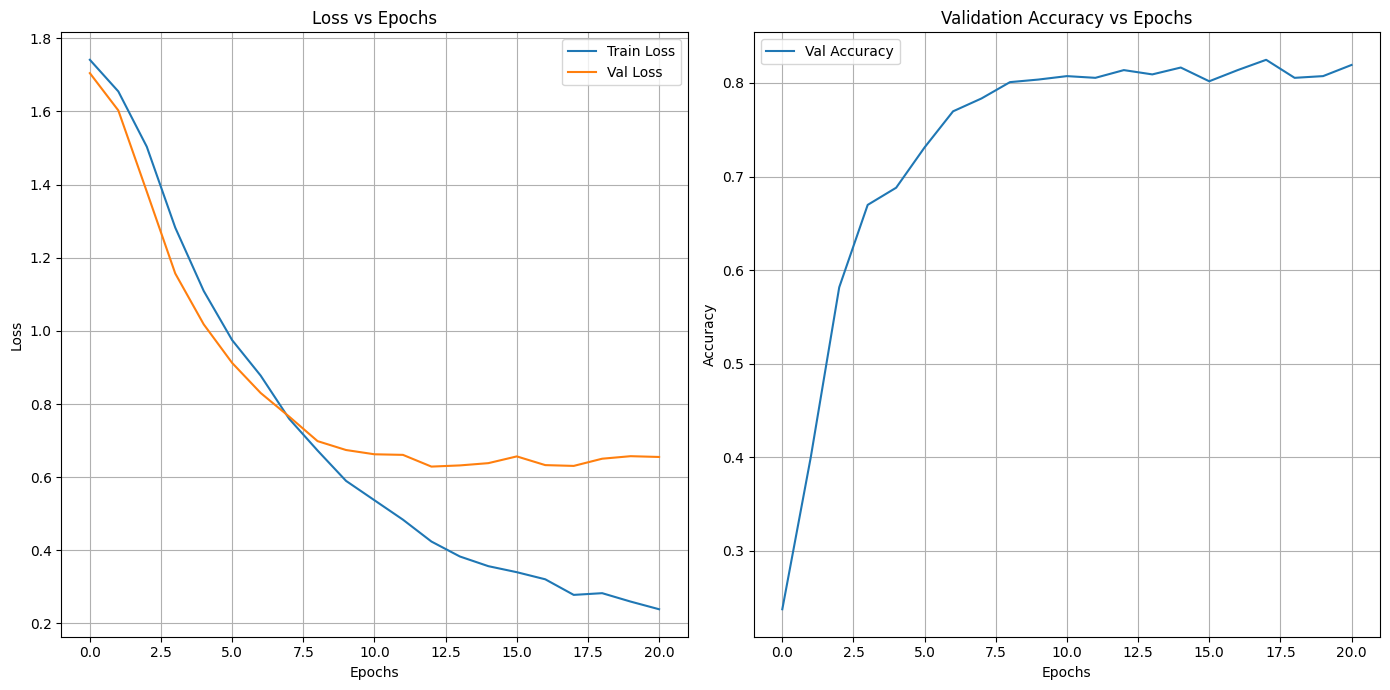

In [99]:
import numpy as np
data = np.load('bilstm_history.npz', allow_pickle=True)
train_loss = data['train_loss']
val_loss = data['val_loss']
val_acc = data['val_acc']

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



## biGRU Model

Compared to RNN, the BiGRU leverages gate mechanisms (update, reset) and processes the sequence in both directions, typically yielding stronger performance on sentence classification.

Hyperparameter tuning (e.g., hidden size, number of layers, dropout) is left out here to assess the base BiGRU (to be added later).

### Approach: 


### Training Details

In [100]:
class BiGRUClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, num_classes,
                 embeddings=None, freeze_embeddings=False, dropout=0.5, pooling='last'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        if embeddings is not None:
            self.embedding.weight.data.copy_(embeddings)
        self.embedding.weight.requires_grad = not freeze_embeddings

        self.gru = nn.GRU(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=True
        )
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * hidden_dim, num_classes)

    def forward(self, text, lengths):
        embedded = self.embedding(text)  # [batch, seq_len, emb_dim]
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, h_n = self.gru(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

        if self.pooling == 'last':
            fwd = h_n[-2, :, :]
            bwd = h_n[-1, :, :]
            sent = torch.cat([fwd, bwd], dim=1)
        elif self.pooling == 'max':
            sent, _ = torch.max(out, dim=1)
        elif self.pooling == 'mean':
            sent = torch.sum(out, dim=1) / (lengths.unsqueeze(1).to(out.device))
        elif self.pooling == 'sum':
            sent = torch.sum(out, dim=1)
        else:
            raise ValueError(f"Unknown pooling: {self.pooling}")

        sent = self.dropout(sent)
        logits = self.fc(sent)
        return logits


In [101]:
bigru_module = BiGRUClassifier(
    vocab_size=vocab_size,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_classes=num_classes,
    embeddings=emb_matrix,
    freeze_embeddings=FREEZE_EMB,
    dropout=DROPOUT,
    pooling=POOLING
)
print(bigru_module)


BiGRUClassifier(
  (embedding): Embedding(8093, 100, padding_idx=0)
  (gru): GRU(100, 8, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=16, out_features=6, bias=True)
)


In [102]:
# --- BiGRU model setup & training ---
bigru_model = BiGRUClassifier(
    vocab_size=vocab_size,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_classes=num_classes,
    embeddings=emb_matrix,
    freeze_embeddings=FREEZE_EMB,
    dropout=DROPOUT,
    pooling=POOLING
).to(DEVICE)

bigru_criterion = nn.CrossEntropyLoss()
bigru_optimizer = optim.Adam(bigru_model.parameters(), lr=LR)

print(bigru_model)

bigru_history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
bigru_best_val_acc = -1.0
bigru_wait = 0

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_loop(bigru_model, train_iter, bigru_optimizer, bigru_criterion)
    va_loss, va_acc = eval_loop(bigru_model, valid_iter, bigru_criterion)

    bigru_history['train_loss'].append(tr_loss)
    bigru_history['val_loss'].append(va_loss)
    bigru_history['val_acc'].append(va_acc)

    print(f"[BiGRU] Epoch {epoch:02d} | Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f} | Val Loss: {va_loss:.4f} | Val Acc: {va_acc:.4f}")

    if va_acc > bigru_best_val_acc:
        bigru_best_val_acc = va_acc
        bigru_wait = 0
        torch.save(bigru_model.state_dict(), 'bigru_best.pt')
    else:
        bigru_wait += 1
        if bigru_wait >= PATIENCE:
            print("[BiGRU] Early stopping triggered.")
            break



BiGRUClassifier(
  (embedding): Embedding(8093, 100, padding_idx=0)
  (gru): GRU(100, 8, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=16, out_features=6, bias=True)
)
[BiGRU] Epoch 01 | Train Loss: 1.7253 | Train Acc: 0.2393 | Val Loss: 1.6741 | Val Acc: 0.2312
[BiGRU] Epoch 02 | Train Loss: 1.6260 | Train Acc: 0.2928 | Val Loss: 1.5889 | Val Acc: 0.3193
[BiGRU] Epoch 03 | Train Loss: 1.5034 | Train Acc: 0.3845 | Val Loss: 1.4289 | Val Acc: 0.4101
[BiGRU] Epoch 04 | Train Loss: 1.3123 | Train Acc: 0.4681 | Val Loss: 1.2613 | Val Acc: 0.4807
[BiGRU] Epoch 05 | Train Loss: 1.1258 | Train Acc: 0.5653 | Val Loss: 1.1038 | Val Acc: 0.6303
[BiGRU] Epoch 06 | Train Loss: 0.9805 | Train Acc: 0.6458 | Val Loss: 1.0027 | Val Acc: 0.6826
[BiGRU] Epoch 07 | Train Loss: 0.8450 | Train Acc: 0.7137 | Val Loss: 0.9221 | Val Acc: 0.7523
[BiGRU] Epoch 08 | Train Loss: 0.7412 | Train Acc: 0.7675 | Val Loss: 0.8761 |

In [103]:

bigru_model.load_state_dict(torch.load('bigru_best.pt', map_location=DEVICE))
bigru_test_loss, bigru_test_acc = eval_loop(bigru_model, test_iter, bigru_criterion)
print(f"[BiGRU] Test Loss: {bigru_test_loss:.4f} | Test Acc: {bigru_test_acc:.4f}")

bigru_topic_acc = topic_eval_loop(bigru_model, test_iter, LABEL.vocab)
print("[BiGRU] Topic-wise accuracy:")
for k, v in bigru_topic_acc.items():
    print(f"  {k}: {v:.4f}")

np.savez('bigru_history.npz',
         train_loss=np.array(bigru_history['train_loss']),
         val_loss=np.array(bigru_history['val_loss']),
         val_acc=np.array(bigru_history['val_acc']))

[BiGRU] Test Loss: 0.5675 | Test Acc: 0.8460
[BiGRU] Topic-wise accuracy:
  HUM: 0.9538
  ENTY: 0.6170
  DESC: 0.9638
  NUM: 0.8584
  LOC: 0.8642
  ABBR: 0.3333


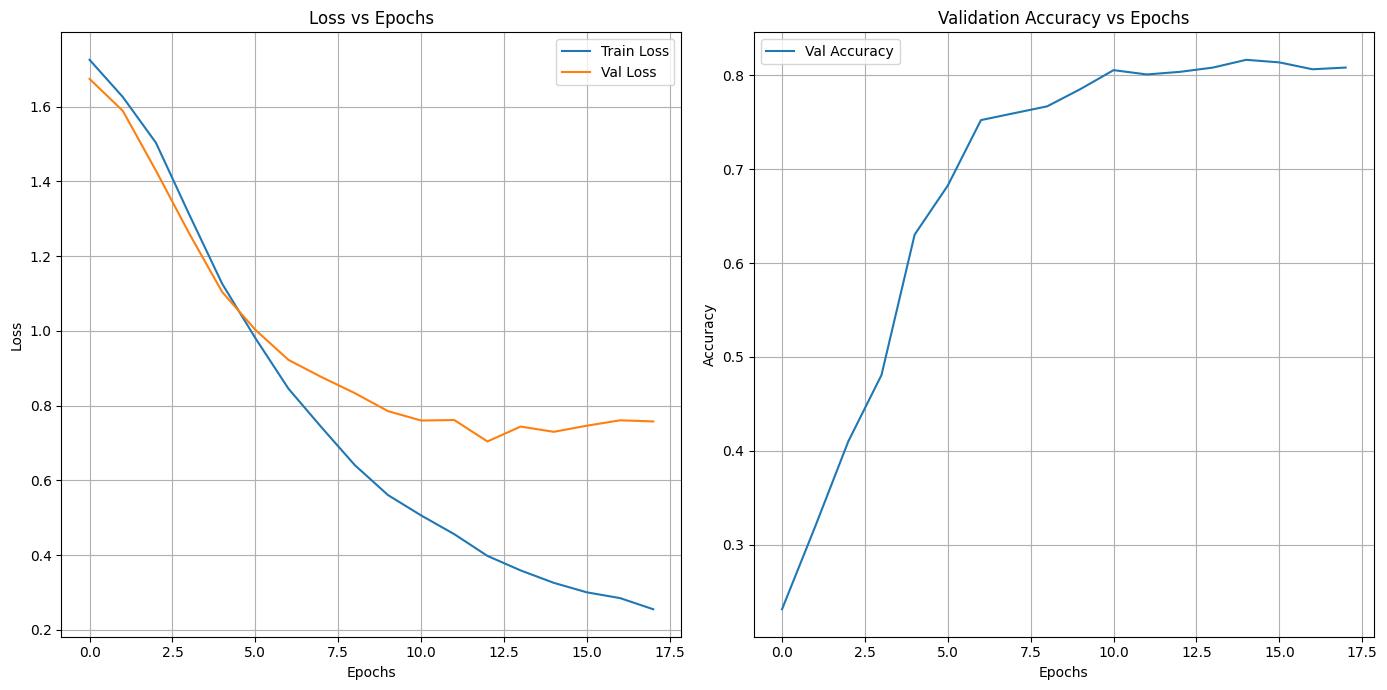

In [104]:
data = np.load('bigru_history.npz', allow_pickle=True)
train_loss = data['train_loss']
val_loss = data['val_loss']
val_acc = data['val_acc']

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
